# Wavelets in Python

[Nicolas Fauchereau](mailto:Nicolas.Fauchereau@gmail.com)

This notebook contains quick comparisons of 3 convenient packages implementing wavelet analysis in Python: 
    
+ waipy 
+ kPywavelets
+ wavelets

we will try and reproduce the example in 

[A practical guide to wavelet analysis](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281998%29079%3C0061%3AAPGTWA%3E2.0.CO%3B2)

from Christopher Torrence and Gil P. Compo

using the NINO3.4 seasonal time series

See also the [Interactive Wavelet page](http://ion.exelisvis.com/)

We will also see the example of rectification of the bias that exist in favor of large scales

## 2018: see https://github.com/aaren/wavelets

### references

+ Torrence, C., and G. P. Compo, 1998: [A practical guide to wavelet analysis](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281998%29079%3C0061%3AAPGTWA%3E2.0.CO%3B2). Bull. Amer. Meteor. Soc., 79, 6178.  


+ Liu, Y., X.S. Liang, and R.H. Weisberg, 2007: Rectification of the bias in the wavelet power spectrum. Journal of Atmospheric and Oceanic Technology, 24(12), 2093-2102. [http://ocgweb.marine.usf.edu/~liu/wavelet.html](http://ocgweb.marine.usf.edu/~liu/wavelet.html)

In [1]:
%matplotlib inline
import numpy as np 
from matplotlib import pyplot as plt

### loads the data 

In [2]:
data = np.loadtxt('../data/sst_nino3.dat')

In [3]:
N = data.size

In [4]:
t0=1871
dt=0.25
units='^{\circ}C'
label='NINO3 SST'

In [5]:
time = np.arange(0, N) * dt + t0

### wavelet from Torrence and Compo

The implementation is from **Dr. Toru Miyama**

+ [http://iprc.soest.hawaii.edu/people/miyama.php](http://iprc.soest.hawaii.edu/people/miyama.php)
+ [https://sites.google.com/site/drtorumiyama/](https://sites.google.com/site/drtorumiyama/)

---- 2018
try https://github.com/aaren/wavelets

In [10]:
import sys

In [11]:
sys.path.append('./')

In [15]:
from wavelib import *

(1870, 2000)

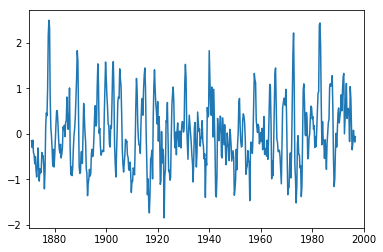

In [16]:
f, ax = plt.subplots()
ax.plot(time,data)
xlim = [1870,2000]  # plotting range
ax.set_xlim(xlim)

In [32]:
from IPython.display import Image
Image("https://camo.githubusercontent.com/aed5bd51b3857fb1913c47a908c5de8511821b9a/68747470733a2f2f7261772e6769746875622e636f6d2f616172656e2f776176656c6574732f6d61737465722f74657374732f636f695f6578616d706c652e706e67")
    

ValueError: Cannot embed the 'com/aed5bd51b3857fb1913c47a908c5de8511821b9a/68747470733a2f2f7261772e6769746875622e636f6d2f616172656e2f776176656c6574732f6d61737465722f74657374732f636f695f6578616d706c652e706e67' image format

In [18]:
variance = np.std(data)**2
mean=np.mean(data)
data = (data - np.mean(data))/np.sqrt(variance)
print("mean=",mean) 
print("std=", np.sqrt(variance)) 

mean= -1.984126984127118e-05
std= 0.7335991128242201


#### set wavelet parameters

In [19]:
pad = 1      # pad the time series with zeroes (recommended)
dj = 0.25    # this will do 4 sub-octaves per octave
s0 = 2.*dt    # this says start at a scale of 6 months
j1 = 7./dj    # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'Morlet'

#### wavelet transform

In [27]:
#wave,period,scale,coi = wavelet(data,dt,pad,dj,s0,j1,mother);
wave,period,scale,coi = wavelet(data,dt,dj,s0,j1,mother);

power = (np.abs(wave))**2         # compute wavelet power spectrum

ValueError: invalid literal for int() with base 10: 'Morlet'

#### significance levels

In [ ]:
signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)
sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,N))) # expand signif --> (J+1)x(N) array
sig95 = power / sig95         # where ratio > 1, power is significant

In [ ]:
global_ws = variance*power.sum(axis=1)/float(N)   # time-average over all times
dof = N - scale  # the -scale corrects for padding at edges
global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

#### scale-average between 2 and 8 years

In [ ]:
avg = (scale >= 2) & (scale < 8)
Cdelta = 0.776;   # this is for the MORLET wavelet
scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,N))) # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg   # [Eqn(24)]
scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)

In [ ]:
iwave=wavelet_inverse(wave, scale, dt, dj, "Morlet")
print "root square mean error",np.sqrt(np.sum((data-iwave)**2)/float(len(data)))*np.sqrt(variance),"deg C"

In [ ]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,data*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(power),np.log2(levels))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels), extend='both', cmap=plt.get_cmap('rainbow'))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_ws,np.log2(period),"r-")
cx.plot(global_signif,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_ws)])

#########################################
#   d) Scale average Spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avg,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signif,scaleavg_signif],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')
plt.savefig("nino3_TorrenceCompo.png")

#### Bias rectification

divides by scales

In [ ]:
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

In [ ]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,data*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(powers),np.log2(levels))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels), extend='both', cmap=plt.get_cmap('rainbow'))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')